In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Input, Embedding, Lambda, Dense, concatenate, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor
import lightgbm as lgb

import datetime
from time import time
import gc

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import lightgbm as lgb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y-test', 'home-depot-product-search-relevance']


# Read the data

In [45]:
train = pd.read_csv('../input/home-depot-product-search-relevance/train.csv', encoding="ISO-8859-1")
test = pd.read_csv('../input/home-depot-product-search-relevance/test.csv', encoding="ISO-8859-1")
prod_att = pd.read_csv('../input/home-depot-product-search-relevance/attributes.csv', encoding="ISO-8859-1")
y_test = pd.read_csv('../input/y-test/solution.csv', encoding="ISO-8859-1")

print('train size', train.shape)
print('test size', test.shape)
print('prod_att size', prod_att.shape)
print('y_test size', y_test.shape)

train size (74067, 5)
test size (166693, 4)
prod_att size (2044803, 3)
y_test size (166693, 3)


# Add test relevence to calculate test MAE

In [46]:
# THIS CELL ADDED ONLY IN THE END AFTER WE GET FINAL MODEL (ON TRAIN SET) 

test = pd.merge(test, y_test, on='id', how='left')
test = test.loc[test['Usage'] != 'Ignored']
test.drop(['Usage'], axis=1, inplace=True)

In [47]:
train_size = train.shape[0]
df_all = pd.concat((train, test), axis=0, ignore_index=True)

In [48]:
df_all.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [49]:
prod_att_metrial = prod_att.loc[prod_att['name'] == 'Material'][['product_uid', 'value']].drop_duplicates(['product_uid'])
prod_att_brand = prod_att.loc[prod_att['name'] == 'MFG Brand Name'][['product_uid', 'value']].drop_duplicates(['product_uid'])

def merge_att(att_df):
    global df_all
    df_all = pd.merge(df_all, att_df, on='product_uid', how='left')
    df_all = df_all.fillna('')
    df_all['product_title'] = df_all['product_title'] + ' ' + df_all['value']
    df_all.drop(['value'], axis=1, inplace=True)
    return df_all

df_all = merge_att(prod_att_metrial)
df_all = merge_att(prod_att_brand)

In [50]:
df_all.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle Galvanized S...,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle Galvanized S...,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


# Split product_titile and search_term to chars

In [53]:
char_to_remove = [' ', '{', '}', '"', '(', ')', '.', ',', '&','[',']','`','_','\'', '~', '\\', '-', ':', ';', '=', '?',
                  '\x80',  '\x81', '\x82', '\x84', '\x89', '\x8b', '\x90', '\x93', '\x95', '\x99', '\x9a', '!',
                  '\x9d', '\xa0', '¡', '¢', '®', 'ª', 'À', 'Ã', 'Â', 'È', 'Ê', 'Ë', 'Ï', 'Ò', 'Û', 
                  'Ü', 'â', 'ã', 'å', 'è', '÷', '$', '*']

def lower_char(char):
    if char >= 'A' and char <= 'Z':
        return char.lower()
    else:
        return char

df_all['product_title'] = df_all['product_title'].apply(lambda sent: [lower_char(character) for character in sent if character not in char_to_remove])
df_all['search_term'] = df_all['search_term'].apply(lambda sent: [lower_char(character) for character in sent if character not in char_to_remove])

In [54]:
df_all.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,"[s, i, m, p, s, o, n, s, t, r, o, n, g, t, i, ...","[a, n, g, l, e, b, r, a, c, k, e, t]",3.00
1,3,100001,"[s, i, m, p, s, o, n, s, t, r, o, n, g, t, i, ...","[l, b, r, a, c, k, e, t]",2.50
2,9,100002,"[b, e, h, r, p, r, e, m, i, u, m, t, e, x, t, ...","[d, e, c, k, o, v, e, r]",3.00
3,16,100005,"[d, e, l, t, a, v, e, r, o, 1, h, a, n, d, l, ...","[r, a, i, n, s, h, o, w, e, r, h, e, a, d]",2.33
4,17,100005,"[d, e, l, t, a, v, e, r, o, 1, h, a, n, d, l, ...","[s, h, o, w, e, r, o, n, l, y, f, a, u, c, e, t]",2.67


# Get all unique chars to preform lable encoder

In [55]:
prod_all_sentences = df_all['product_title']
search_all_sentences = df_all['search_term']

all_unique_chars = np.unique(np.concatenate((prod_all_sentences.append(search_all_sentences).values), axis=None))
all_unique_chars = np.append(['<uniq>'], all_unique_chars)

In [56]:
all_unique_chars

array(['<uniq>', '#', '%', '+', '/', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
       'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
       'x', 'y', 'z'], dtype='<U6')

# Replace tokens in numbers using lable encoder

In [57]:
def token_to_num(data, unique_valus):
    le = LabelEncoder()
    le.fit(unique_valus)
    data['product_title'] = data['product_title'].apply(lambda char_list: le.transform(char_list).astype(float)) 
    data['search_term'] = data['search_term'].apply(lambda char_list: le.transform(char_list).astype(float)) 
    return data

df_all = token_to_num(df_all, all_unique_chars)

In [58]:
df_all.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,"[33.0, 23.0, 27.0, 30.0, 33.0, 29.0, 28.0, 33....","[15.0, 28.0, 21.0, 26.0, 19.0, 16.0, 32.0, 15....",3.00
1,3,100001,"[33.0, 23.0, 27.0, 30.0, 33.0, 29.0, 28.0, 33....","[26.0, 16.0, 32.0, 15.0, 17.0, 25.0, 19.0, 34.0]",2.50
2,9,100002,"[16.0, 19.0, 22.0, 32.0, 30.0, 32.0, 19.0, 27....","[18.0, 19.0, 17.0, 25.0, 29.0, 36.0, 19.0, 32.0]",3.00
3,16,100005,"[18.0, 19.0, 26.0, 34.0, 15.0, 36.0, 19.0, 32....","[32.0, 15.0, 23.0, 28.0, 33.0, 22.0, 29.0, 37....",2.33
4,17,100005,"[18.0, 19.0, 26.0, 34.0, 15.0, 36.0, 19.0, 32....","[33.0, 22.0, 29.0, 37.0, 19.0, 32.0, 29.0, 28....",2.67


# Check max product description and search term length to know how much padding needed

In [59]:
def get_max_length(data):
    max_len = 0
    for i in range(0, len(data)):
        if len(data.iloc[i]) > max_len:
            max_len = len(data.iloc[i])
    return max_len

def get_avg_length(data):
    len_sum = 0
    for i in range(0, len(data)):
        len_sum += len(data.iloc[i])
    return int(len_sum / len(data))

avg_length_prod = get_avg_length(df_all['product_title'])
avg_length_search = get_avg_length(df_all['search_term'])

max_length_prod = get_max_length(df_all['product_title'])
max_length_search = get_max_length(df_all['search_term'])

In [60]:
print('avg_length_prod', avg_length_prod)
print('avg_length_search', avg_length_search)

print('max_length_prod', max_length_prod)
print('max_length_search', max_length_search)

avg_length_prod 65
avg_length_search 16
max_length_prod 301
max_length_search 53


# Split back to train and test sets

In [61]:
df_train = df_all.iloc[:train_size]
df_test = df_all.iloc[train_size:]
df_test.reset_index(inplace=True, drop=True)

y_data = df_train['relevance']

# transform relevance to labels

In [62]:
le_labels = LabelEncoder()
le_labels.fit(y_data.unique())
y_data_labels = le_labels.transform(y_data)

# Split to two sides:
1. search_term
2. product_desctiption + title

In [63]:
X_data = {'left': df_train['product_title'], 'right': df_train['search_term']}
X_test = {'left': df_test['product_title'], 'right': df_test['search_term']}

# Add zero padding to each char list in size of max_length

In [64]:
for dataset in [X_data, X_test]:
    dataset['left'] = pad_sequences(dataset['left'], maxlen=avg_length_prod)
    dataset['right'] = pad_sequences(dataset['right'], maxlen=avg_length_search)

In [65]:
# def reshpe_data(data):
#     data['left'] = np.reshape(data['left'], (data['left'].shape[0], data['left'].shape[1], 1))
#     data['right'] = np.reshape(data['right'], (data['right'].shape[0], data['right'].shape[1], 1))  
#     return data

# X_data = reshpe_data(X_data)
# X_test = reshpe_data(X_test)

# Normalized the label

In [66]:
# mean_val = y_data.mean()
# std_val = y_data.std()
# y_data_norm = (y_data - mean_val) / std_val

min_val = y_data.min()
max_val = y_data.max()
y_data_norm = (y_data - min_val) / (max_val - min_val)

# Create one-hot to each char

In [67]:
def create_onehot(data):
    onehot_all = []
    for line in data:
        onehot_encoded = []
        for char in line:
            onehot = np.zeros(len(all_unique_chars)) #[0 for _ in range(len(all_unique_chars))]
            onehot[char] = 1
            onehot_encoded.append(onehot)
        onehot_all.append(onehot_encoded)
    return np.reshape(onehot_all, (len(onehot_all), len(onehot_all[0]), len(onehot_all[0][0])))

X_data['left'] = create_onehot(X_data['left'])
X_data['right'] = create_onehot(X_data['right'])
X_test['left'] = create_onehot(X_test['left'])
X_test['right'] = create_onehot(X_test['right'])

In [68]:
print('X_train left shape', X_data['left'].shape)
print('X_train right shape', X_data['right'].shape)
print('y_train shape', y_data.shape)

print('X_test left shape', X_test['left'].shape)
print('X_test right shape', X_test['right'].shape)

X_train left shape (74067, 65, 41)
X_train right shape (74067, 16, 41)
y_train shape (74067,)
X_test left shape (112067, 65, 41)
X_test right shape (112067, 16, 41)


# Cleare space in memory

In [69]:
del train
del prod_att
del df_all
gc.collect()

7

# Build the model

In [70]:
# Model variables
n_lstm_hidden = 25
batch_size = 128
n_epoch = 5

def get_model():

    # input layer
    left_input = Input(shape=(avg_length_prod, len(all_unique_chars)))
    right_input = Input(shape=(avg_length_search, len(all_unique_chars)))

    # LSTM layer
    shared_lstm = LSTM(n_lstm_hidden)
    left_output = shared_lstm(left_input)
    right_output = shared_lstm(right_input)

    # batch normalization layer
    left_output = BatchNormalization()(left_output)
    right_output = BatchNormalization()(right_output)
    
    # concat two outputs
    concat = concatenate([left_output, right_output])
    
    dense_1 = Dense(50, activation="relu")(concat)
    dropout_1 = Dropout(0.1)(dense_1)

    # add Dense layer to calculate the similarty between product title and search term
    output = Dense(1, activation="relu")(dropout_1)

    # Pack it all up into a model
    siamese_model = Model([left_input, right_input], output)

    # colmpiling
    siamese_model.compile(loss='mse', optimizer='adam')
    return siamese_model

In [71]:
def split_to_train_val(data_x, data_y, train_index, val_index):
    train_left = data_x['left'][train_index]
    train_right = data_x['right'][train_index]
    y_train = data_y[train_index]  
    val_left = data_x['left'][val_index]
    val_right = data_x['right'][val_index]
    y_val = data_y[val_index]
    
    return train_left, train_right, val_left, val_right, y_train, y_val

In [72]:
# Plot loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [73]:
def plot_fiting(y_pred, y_true):
    n_samples = 100
    axis=[x for x in range(n_samples)]
    plt.plot(axis, y_true[:n_samples], marker='.', label="actual")
    plt.plot(axis, y_pred[:n_samples], 'r', label="prediction")
    plt.ylabel('Relevance', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

In [74]:
mean_mae_train = 0
mean_rmse_train = 0
mean_mae_val = 0
mean_rmse_val = 0

def eval_mean(y_true, y_pred, is_val=True):
    global mean_mae_train, mean_rmse_train, mean_mae_val, mean_rmse_val
    
    y_true_norm = (y_true * (max_val - min_val)) + min_val
    y_pred_norm = (y_pred * (max_val - min_val)) + min_val
    
    mae_value = mean_absolute_error(y_true_norm, y_pred_norm)
    rmse_value = sqrt(mean_squared_error(y_true_norm, y_pred_norm))
    
    if is_val:
        mean_mae_val += (mae_value / n_splits)
        mean_rmse_val += (rmse_value / n_splits)
    else:
        mean_mae_train += (mae_value / n_splits)
        mean_rmse_train += (rmse_value / n_splits)
        
    print('mae_value', mae_value)
    print('rmse_value', rmse_value)

# StratifiedKFold cross validation

Train on 37030 samples, validate on 37037 samples
Epoch 1/5
37030/37030 [==============================] - 23s 609us/step - loss: 0.1484 - val_loss: 0.0811
Epoch 2/5
37030/37030 [==============================] - 20s 532us/step - loss: 0.0795 - val_loss: 0.0722
Epoch 3/5
37030/37030 [==============================] - 20s 531us/step - loss: 0.0735 - val_loss: 0.0700
Epoch 4/5
37030/37030 [==============================] - 19s 525us/step - loss: 0.0709 - val_loss: 0.0697
Epoch 5/5
37030/37030 [==============================] - 20s 532us/step - loss: 0.0696 - val_loss: 0.0694
mae_value 0.42571212006297715
rmse_value 0.5169133075142155
mae_value 0.4335321992484611
rmse_value 0.5267634768764897


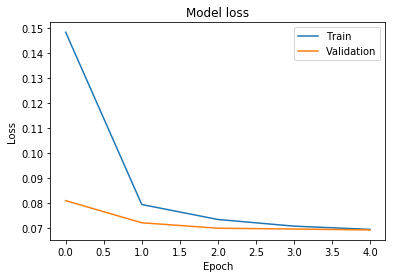

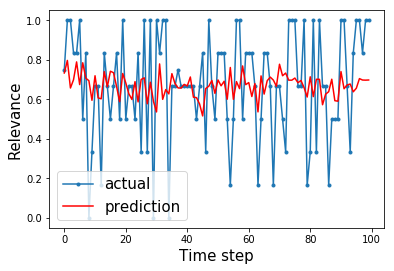

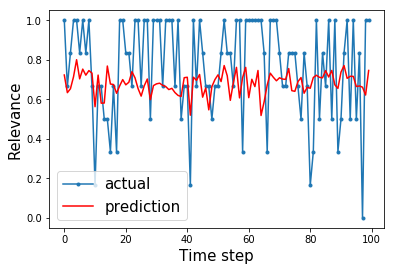

Train on 37037 samples, validate on 37030 samples
Epoch 1/5
37037/37037 [==============================] - 23s 619us/step - loss: 0.1252 - val_loss: 0.0792
Epoch 2/5
37037/37037 [==============================] - 20s 537us/step - loss: 0.0793 - val_loss: 0.0764
Epoch 3/5
37037/37037 [==============================] - 20s 548us/step - loss: 0.0736 - val_loss: 0.0710
Epoch 4/5
37037/37037 [==============================] - 19s 509us/step - loss: 0.0710 - val_loss: 0.0699
Epoch 5/5
37037/37037 [==============================] - 19s 502us/step - loss: 0.0698 - val_loss: 0.0696
mae_value 0.4254618309991072
rmse_value 0.5189927275320982
mae_value 0.43348445484685216
rmse_value 0.5275639659889262


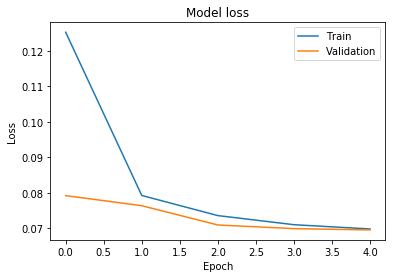

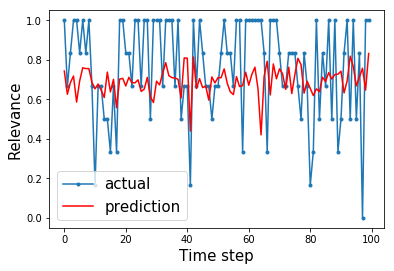

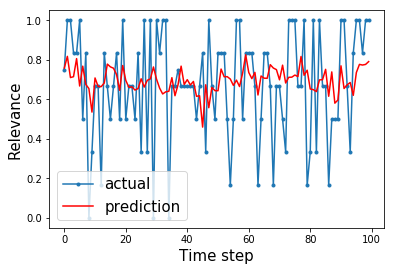

mean_mae_train 0.4255869755310422
mean_rmse_train 0.5179530175231568
mean_mae_val 0.4335083270476566
mean_rmse_val 0.527163721432708
end time 315.603
mean train time 103.3055
mean pred time 31.086


In [75]:
pred_test = np.zeros(X_test['left'].shape[0])

n_splits = 2
# kfold = KFold(n_splits=n_splits, shuffle=True, random_state=24)
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

mean_train_time = 0
mean_pred_time = 0
start_time = time()

for train_index, test_index in kfold.split(X_data['left'], y_data_labels):    
    X_train_left_kfold, X_train_right_kfold, X_val_left_kfold, X_val_right_kfold, y_train_kfold, y_val_kfold = split_to_train_val(X_data, y_data_norm.values, train_index, test_index)
    
    start = time()
    siamese_model = get_model()
    history = siamese_model.fit([X_train_left_kfold, X_train_right_kfold], y_train_kfold,
                            batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_val_left_kfold, X_val_right_kfold], y_val_kfold))
    mean_train_time += (round(time()-start, 3) / n_splits)
    
    pred_train = siamese_model.predict([X_train_left_kfold, X_train_right_kfold])
    pred_val = siamese_model.predict([X_val_left_kfold, X_val_right_kfold])
    eval_mean(y_train_kfold, pred_train, False)
    eval_mean(y_val_kfold, pred_val, True)
    
    start = time()
    pred_test += np.reshape((siamese_model.predict([X_test['left'], X_test['right']]) / n_splits), (len(pred_test),))   
    mean_pred_time += (round(time()-start, 3) / n_splits)
    
    plot_loss(history)
    plot_fiting(pred_train, y_train_kfold)
    plot_fiting(pred_val, y_val_kfold)
    
print('mean_mae_train', mean_mae_train)
print('mean_rmse_train', mean_rmse_train)
print('mean_mae_val', mean_mae_val)
print('mean_rmse_val', mean_rmse_val)
print('end time', round(time()-start_time, 3))
print('mean train time', mean_train_time)
print('mean pred time', mean_pred_time)

# Use the model we got as feature extractor 
1. for XGBoost model
2. for lightgbm model

In [76]:
# split to train and validation sets
train_indx = int(0.8*X_data['left'].shape[0])
X_train_left = X_data['left'][:train_indx]
X_val_left = X_data['left'][train_indx:]
X_train_right = X_data['right'][:train_indx]
X_val_right = X_data['right'][train_indx:]
y_train = y_data_norm[:train_indx]
y_val = y_data_norm[train_indx:]

print('X_train_left shape', X_train_left.shape)
print('X_val_left shape', X_val_left.shape)
print('X_train_right shape', X_train_right.shape)
print('X_val_right shape', X_val_right.shape)
print('y_train shape', y_train.shape)
print('y_val shape', y_val.shape)

X_train_left shape (59253, 65, 41)
X_val_left shape (14814, 65, 41)
X_train_right shape (59253, 16, 41)
X_val_right shape (14814, 16, 41)
y_train shape (59253,)
y_val shape (14814,)


In [77]:
# Train the model on train and then predict train, val and test to get features
siamese_model = get_model()
history = siamese_model.fit([X_train_left, X_train_right], y_train.values, batch_size=batch_size, epochs=n_epoch)

# get the output of the concat layer and use it as features to the ml models
concat_layer = siamese_model.layers[5].output
feature_model = Model(siamese_model.input, concat_layer)
feature_model.compile(loss='mse', optimizer='adam')
print(feature_model.summary())

# we use the output of the concat layer as fetures so they will be the input to the xgb and lgb models
featurs = feature_model.predict([X_train_left, X_train_right])

# we preform the prediction also on the test set to evaluate rmse and mae on val set
features_val = feature_model.predict([X_val_left, X_val_right])

# we preform the prediction also on the test set to evaluate the mse on test set
features_test = feature_model.predict([X_test['left'], X_test['right']])

Epoch 1/5
59253/59253 [==============================] - 27s 455us/step - loss: 0.1252
Epoch 2/5
59253/59253 [==============================] - 24s 403us/step - loss: 0.0726
Epoch 3/5
59253/59253 [==============================] - 24s 402us/step - loss: 0.0696
Epoch 4/5
59253/59253 [==============================] - 24s 408us/step - loss: 0.0682
Epoch 5/5
59253/59253 [==============================] - 25s 415us/step - loss: 0.0675
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 65, 41)       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 16, 41)       0                                            
______________________________________________________________________

In [78]:
# xgb
start1 = time()
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.6, colsample_bytree=1, max_depth=3)
xgb_model.fit(featurs, y_train)
print("xgb train time", round(time()-start1, 3))

start2 = time()
xgb_pred_test = xgb_model.predict(features_test)
print("xgb predict time", round(time()-start2, 3))
print("xgb total time", round(time()-start1, 3))
xgb_pred_val = xgb_model.predict(features_val)
xgb_pred_train = xgb_model.predict(featurs)

# lgb
start1 = time()
lgb_model = lgb.sklearn.LGBMRegressor(is_unbalance=True, learning_rate =0.01, subsample=0.6, colsample_bytree=0.6, max_depth=5, num_leaves=60)
lgb_model.fit(featurs, y_train)
print("lgb train time", round(time()-start1, 3))

start2 = time()
lgb_pred_test = lgb_model.predict(features_test)
print("lgb predict time", round(time()-start2, 3))
print("lgb total time", round(time()-start1, 3))
lgb_pred_val = lgb_model.predict(features_val)
lgb_pred_train = lgb_model.predict(featurs)

xgb train time 15.057
xgb predict time 0.379
xgb total time 15.437
lgb train time 1.85
lgb predict time 0.813
lgb total time 2.664


siamese test


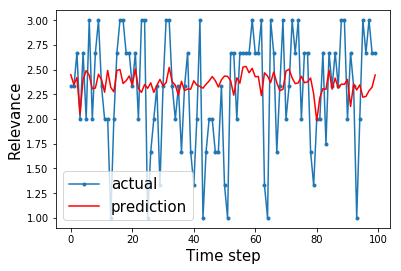

lgb test


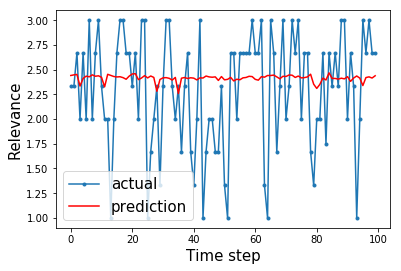

xgb test


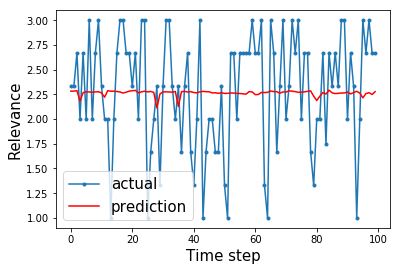

lgb train


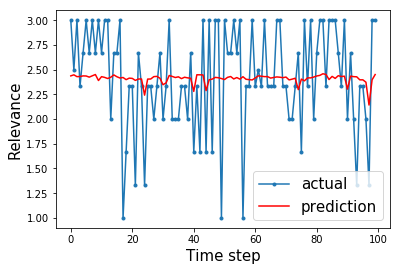

xgb train


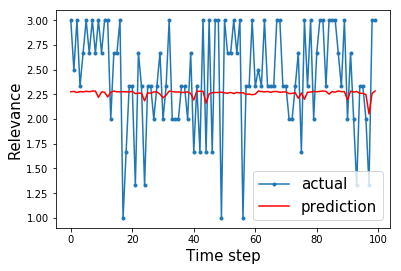

lgb val


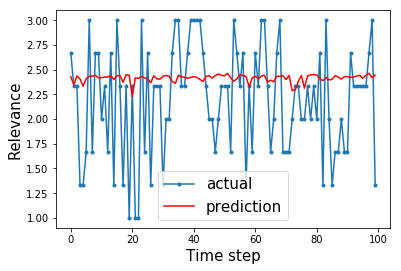

xgb val


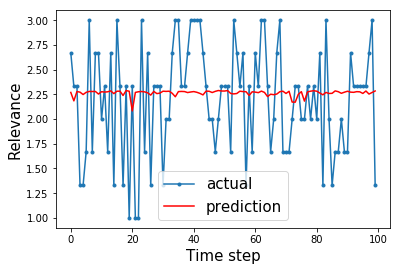

In [82]:
def round_pred(pred):
    pred = (pred * (max_val - min_val)) + min_val
    for i in range(0,len(pred)):
        if pred[i] < 1:
            pred[i] = 1
        if pred[i] > 3:
            pred[i] = 3
    return pred

def eval_festure(y_true, y_pred, title):
    print(title, 'mae', mean_absolute_error(y_true, y_pred))
    print(title, 'rmse', sqrt(mean_squared_error(y_true, y_pred)))

xgb_pred_test = round_pred(xgb_pred_test.astype(float))
lgb_pred_test = round_pred(lgb_pred_test.astype(float))

xgb_pred_train = round_pred(xgb_pred_train.astype(float))
lgb_pred_train = round_pred(lgb_pred_train.astype(float))

xgb_pred_val = round_pred(xgb_pred_val.astype(float))
lgb_pred_val = round_pred(lgb_pred_val.astype(float))

pred_test = (pred_test * (max_val - min_val)) + min_val

eval_festure(test['relevance'], pred_test, 'pred_test')
eval_festure(test['relevance'], lgb_pred_test, 'lgb_pred_test')
eval_festure(y_train, lgb_pred_train, 'lgb_pred_train')
eval_festure(y_val, lgb_pred_val, 'lgb_pred_val')
eval_festure(test['relevance'], xgb_pred_test, 'xgb_pred_test')
eval_festure(y_train, xgb_pred_train, 'xgb_pred_train')
eval_festure(y_val, xgb_pred_val, 'xgb_pred_val')

print('siamese test')
plot_fiting(pred_test, test['relevance'])
print('lgb test')
plot_fiting(lgb_pred_test, test['relevance'])
print('xgb test')
plot_fiting(xgb_pred_test, test['relevance'])

y_train = (y_train * (max_val - min_val)) + min_val
y_val = (y_val * (max_val - min_val)) + min_val

print('lgb train')
plot_fiting(lgb_pred_train, y_train)
print('xgb train')
plot_fiting(xgb_pred_train, y_train)

print('lgb val')
plot_fiting(lgb_pred_val, y_val)
print('xgb val')
plot_fiting(xgb_pred_val, y_val)

# Write predictions to sample submission file

In [ ]:
sample_sub = pd.DataFrame()
sample_sub['id'] = test['id']
sample_sub['relevance'] = pred_test
sample_sub.to_csv('sample_submmision_char_siamese.csv', index=False)